# BOIP Figures

## Table of Contents
- [Surface/Regret plots](#regret-and-surface)
- [False hit pruning / Uncertainty (in/de)flation plots](#false-hit-pruning)
- [Design space pruning](#design-space-pruning)

In [9]:
from pathlib import Path
from typing import Iterable, Optional

from botorch.test_functions.base import BaseTestProblem
from matplotlib import pyplot as plt, patheffects as pe
from matplotlib.ticker import MultipleLocator
import numpy as np
from scipy import stats
import seaborn as sns
import torch
from torch import Tensor

import boip

sns.set_theme("talk", "white")

## Regret and Surface

[back to top](#table-of-contents)

In [10]:
def immediate_regret(Y: np.ndarray, optima: np.ndarray, k: int = 1):
    """calculate the immediate top-k regret for the observed values given the objective top-k
    optima

    Parameters
    ----------
    Y : np.ndarray
        an `r x t` array, where r is the number of repeats and t is the number of observations made
        for a given trial. Each entry is the observation made at iteration t
    optima : np.ndarray
        a length `k` vector containing the optima of the objective function
    k : int, default=1
        the number of top-k points which are being optimized for

    Returns
    -------
    np.ndarray
        an `r x t` array containing the immediate regret at the given iteration, where r is number of repititions and t is number of iterations. "Immediate regret" is formulated as the
        fraction of the total number of optima found. NOTE: it is possible for there to be
        degenerate hits
    """
    t = optima.min()
    Y_star = np.empty(Y.shape)
    for i in range(k, Y.shape[1]):
        Y_star[:,i] = (np.partition(Y[:,:i+1], -k, 1)[:, -k:] >= t).sum(1)
        
    return Y_star / len(optima)

def plot_IR(
    ax,
    Ys: Iterable[np.ndarray],
    N: int,
    optima: np.ndarray,
    labels: Iterable[str],
    obj,
    choices,
    k: int = 1
):
    """plot the immediate regret curves of the dataset onto axis ax

    Parameters
    ----------
    ax
        the axis on which to plot the curves
    Ys : Iterable[np.ndarray]
        an iterable of `r x t` arrays, where each entry is the observation made at
        iteration t of trial r for a specific dataset
    obj : BaseTestProblem
        the objective these datasets are attempting to minimize
    N : int
        the number of initial random observations
    labels : Optional[Iterable[str]]
        the label of each trace
    optima: np.ndarray
        the optimal objective values
    budget: Optional[float], default=None
        the maximum budget to plot until on the x-axis. If None, plot entire trace
    cost: float, default=0.
        the simulated cost of an objective function evaluation

    Returns
    -------
    ax
        the axis on which the curves were plotted
    """
    for Y, label in zip(Ys, labels):
        R = immediate_regret(Y, optima, k)[:, N:]
        x = np.arange(Y.shape[1])[N:]

        r = R.mean(0)
        r_se = stats.sem(R, 0)
        ax.plot(
            x,
            r,
            label=label,
            lw=5,
            path_effects=[pe.Stroke(linewidth=7.5, foreground="k"), pe.Normal()],
        )
        ax.fill_between(x, r-r_se, r+r_se, alpha=0.3, dashes=":", lw=2.0, ec="black")

    R = gen_R_random(obj, *Y.shape, optima, choices, k)[:, N:]
    r = R.mean(0)
    r_se = stats.sem(R, 0)
    ax.plot(
        x,
        r,
        c="grey",
        label="random",
        lw=5,
        path_effects=[pe.Stroke(linewidth=7.5, foreground="k"), pe.Normal()],
    )
    ax.fill_between(x, r-r_se, r+r_se, color="grey", alpha=0.7, dashes=":", lw=2.0, ec="black")

    return ax

def gen_R_random(
    obj,
    r: int,
    n: int,
    optima: Tensor,
    choices: Tensor,
    k: int = 1
):
    """add a trace for random acquisition

    Parameters
    ----------
    obj
        the objective to generate the trace for
    r : int
        the number of repeats
    n : int
        the number of samples to take

    Returns
    -------
    np.ndarray
        the immediate regret matrix for random acquisition
    """
    idxs = torch.empty((r, n)).long()
    for i in range(r):
        idxs[i] = torch.randperm(len(choices))[:n]

    X = choices[idxs]
    Y = obj(X).numpy()

    return immediate_regret(Y, optima, k)

def plot_surface(
    ax,
    obj: BaseTestProblem,
    Xs: np.ndarray,
    optimal_choices: np.ndarray,
    title: Optional[str] = None,
):
    """plot the level surface of the given objective onto the specified axis

    Parameters
    ----------
    ax
        the axis onto which the level surface should be plotted
    obj : BaseTestProblem
        the objective to which the level surface corresponds
    Xs : Iterable[np.ndarray]
        an iterable of `r x t x d` arrays. Where each entry in each array corresponds to the
        d-dimensional point acquired at iteration t of trial r
    optimal_choices: np.ndarray
    title : Optional[str], default=None
        the title to use for the plot. If None, use the name of the objective function

    Returns
    -------
    ax
        the axis on which the surface was plotted
    """
    X1_bounds, X2_bounds = zip(*obj.bounds.numpy())
    x1 = np.linspace(*X1_bounds, 100)
    x2 = np.linspace(*X2_bounds, 100)

    X1, X2 = np.meshgrid(x1, x2)
    Z = -obj(torch.from_numpy(np.stack((X1, X2), axis=2))).numpy()

    cs1 = ax.contourf(X1, X2, Z, 8, cmap="coolwarm", zorder=0, alpha=0.7)
    ax.contour(X1, X2, Z, cs1.levels, colors='k', alpha=0.5, linestyles='solid')

    ax.plot(optimal_choices[:, 0], optimal_choices[:, 1], "y*", ms=12, mec="black", zorder=2)

    ax.set_title(title if title is not None else str(obj)[:-2])
    ax.tick_params(
        labelcolor="none",
        which="both",
        top=False,
        bottom=False,
        left=False,
        right=False,
    )

    # if Xs is not None and strategy is not None:
    #     idx = np.random.randint(len(Xs[strategy.value]))
    #     points = Xs[strategy.value][idx][: N + max_idxs[strategy.value]]
    #     ax.scatter(
    #         points[:, 0],
    #         points[:, 1],
    #         s=10.0,
    #         marker="x",
    #         c=np.arange(len(points)),
    #         cmap="viridis",
    #         vmin=N,
    #         zorder=1,
    #     )

    return ax

In [11]:
def plot_size_S(ax, S: np.ndarray, q: int):
    """plot the input space size using the size history

    Parameters
    ----------
    ax
        the axis on which to plot
    S : np.ndarray
        an `r x T` array containing the size of the input space at the given iteration, where r is 
        the number of repetitions and T is 1 + the number of optimization iterations
    q : int
        the batch/initialization size
    """
    x = q * (1 + np.arange(S.shape[1]))
    S = S/S[0, 0]

    s = S.mean(0)
    s_se = stats.sem(S, 0)
    ax.plot(
        x,
        s,
        c='g',
        lw=2.5,
        path_effects=[pe.Stroke(linewidth=5, foreground="k"), pe.Normal()],
        label="size"
    )
    ax.fill_between(x, s-s_se, s+s_se, color='g', alpha=0.3, dashes=":", lw=2.0, ec="black")
    
    return ax

def plot_size_H(ax, H, q: int, T: int):
    """plot the input space size using the pruning history

    Parameters
    ----------
    ax
        the axis on which to plot
    H : np.ndarray
        an `r x n` array containing the pruning history of each point, where r is the number of repeats and n is the total input space size. The value of each entry is the iteration at
        which the given point was pruned from the input space, with a -1 indicating that the
        point was never pruned
    q : int
        the batch/initialization size
    T : int
        the number of optimzation iterations
    """
    N = H.shape[1]
    N_prune_t = np.empty((len(H), T+1), int)
    for t in range(N_prune_t.shape[1]):
        N_prune_t[:, t] = (H == t).sum(1)

    S = N - np.cumsum(N_prune_t, 1)
    x = q * (1+np.arange(S.shape[1]))

    S = S/S[0, 0]
    s = S.mean(0)
    s_se = stats.sem(S, 0)

    ax.plot(
        x,
        s,
        'g--',
        lw=2.5,
        path_effects=[pe.Stroke(linewidth=5, foreground="k"), pe.Normal()],
        label="size",
    )
    ax.fill_between(x, s-s_se, s+s_se, color='g', alpha=0.3, lw=2.0)
    
    return ax

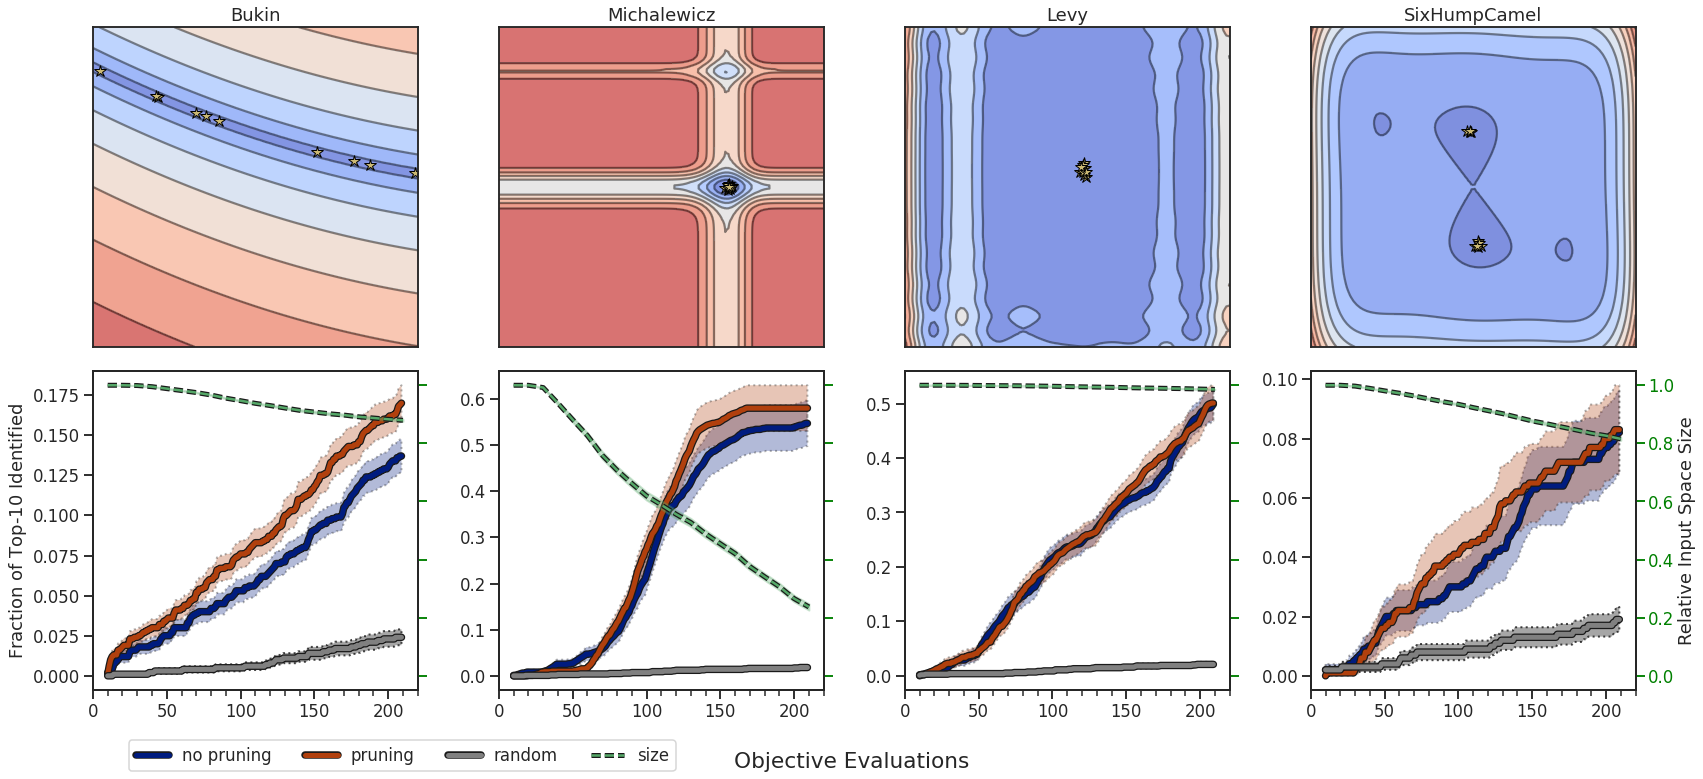

In [12]:
runs_dir = Path.home() / "active-projects/boip/runs/10000-10+20x10-new"
npzdirs = list(runs_dir.iterdir())

npzdirs = [
    Path('/home/degraff/active-projects/boip/runs/10000-10+20x10-new/bukin'),
    Path('/home/degraff/active-projects/boip/runs/10000-10+20x10-new/michalewicz'),
    Path('/home/degraff/active-projects/boip/runs/10000-10+20x10-new/levy'),
    Path('/home/degraff/active-projects/boip/runs/10000-10+20x10-new/camel')
]

# npzdirs = [
#     Path('/home/degraff/active-projects/boip/runs/10000-10+200x10-multi/bukin'),
#     Path('/home/degraff/active-projects/boip/runs/10000-10+200x10-multi/michalewicz'),
#     Path('/home/degraff/active-projects/boip/runs/10000-10+200x10-multi/levy'),
#     Path('/home/degraff/active-projects/boip/runs/10000-10+200x10-multi/camel')
# ]

objs = [boip.objectives.build_objective(p.stem) for p in npzdirs]
n = 10
k = 10
q = 10
T = 20

sns.set_palette(sns.color_palette("dark"))
fig, axs = plt.subplots(2, len(objs), figsize=(6 * len(objs), 11))

axs_2 = []
for i, (obj, npzdir) in enumerate(zip(objs, npzdirs)):
    choices = boip.objectives.discretize(obj, 10000, 42)

    X_npz = np.load(f"{npzdir}/X.npz")
    Y_npz = np.load(f"{npzdir}/Y.npz")
    H = np.load(f"{npzdir}/H.npz")["PRUNE"]

    Xs = [X_npz[k] for k in X_npz]
    Ys = [Y_npz[k] for k in Y_npz]

    y_all = obj(choices).numpy()
    optimal_idxs = np.argpartition(y_all, -k)[-k:]
    optimal_choices = choices[optimal_idxs]
    optima = y_all[optimal_idxs]

    plot_surface(axs[0][i], obj, Xs, optimal_choices)

    ax1 = plot_IR(axs[1][i], Ys, n, optima, ["no pruning", "pruning"], obj, choices, k)
    ax2 = ax1.twinx()
    ax2 = plot_size_H(ax2, H[:,:,1], q, T)
    axs_2.append(ax2)

    ax1.xaxis.set_minor_locator(MultipleLocator(10))
    ax1.tick_params(axis="x", which="both", direction="out", bottom=True)

for ax2 in axs_2[:-1]:
    ax2.sharey(axs_2[-1])
    ax2.tick_params('y', labelright=False, colors='green')
axs_2[-1].set_ylim(top=1.05, bottom=-0.05)
axs_2[-1].tick_params('y', colors='green')

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
fig.legend(
    [*handles1, *handles2],
    [*labels1, *labels2],
    ncol=4,
    bbox_to_anchor=(0.24, 0),
    loc="lower center",
)

fig.supxlabel("Objective Evaluations")
axs[1][0].set_ylabel(r"Fraction of Top-$10$ Identified")
axs_2[-1].set_ylabel("Relative Input Space Size")

fig.tight_layout()
fig.subplots_adjust(wspace=0.25, hspace=0.075)

In [16]:
fig.savefig("../figures/some-objs-10+20x10_hit-finding.png", dpi=200)

## False Hit Pruning

[back to top](#table-of-contents)

In [13]:
def f_hits_pruned(H, hit_idxs, T):
    hits_pruned_t = np.zeros((len(H), T+1))
    for t in range(hits_pruned_t.shape[1]):
        hits_pruned_t[:, t] = (H[:, hit_idxs] == t).sum(1)

    return np.cumsum(hits_pruned_t, 1) / len(hit_idxs)
    
def calc_FNR(P_fn: float, acq_rate: float, T: int) -> np.ndarray:
    """calculate the false negative rate for the given iteration
    
    Parameters
    ----------
    P_fn : float
        the probability of a false negative
    acq_rate : float
        the fraction of remaining positives that are acquired at each iteration
    T : int
        the total number of iterations
    
    Returns
    -------
    FNR : np.ndarray
        a vector of length `T` containing the false negative rate at each iteration
    """
    F_hits = ((1-P_fn) * (1-acq_rate))**np.arange(T)
    return P_fn * np.cumsum(F_hits)
    

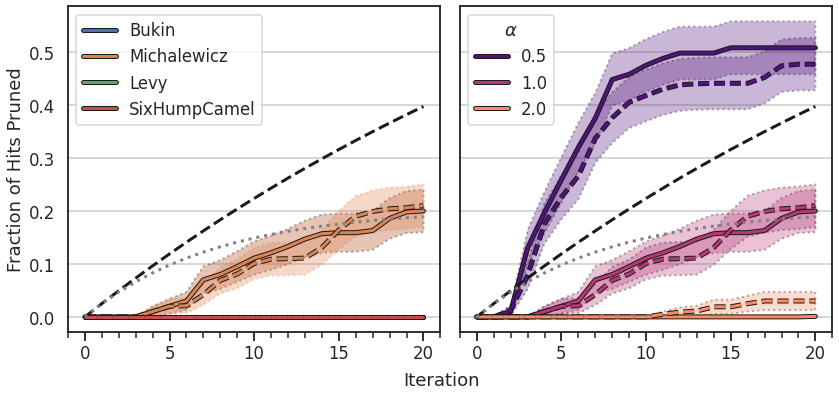

In [18]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(6*2, 6))

N = 10000
ds = 42
k = 10
T = 20
t = np.arange(T+1)

###------------------------ OBJECTIVES PANEL ------------------------###
ax = axs[0]

npzdirs = [
    Path('/home/degraff/active-projects/boip/runs/10000-10+20x10-new/bukin'),
    Path('/home/degraff/active-projects/boip/runs/10000-10+20x10-new/michalewicz'),
    Path('/home/degraff/active-projects/boip/runs/10000-10+20x10-new/levy'),
    Path('/home/degraff/active-projects/boip/runs/10000-10+20x10-new/camel')
]
objs = [boip.objectives.build_objective(p.stem) for p in npzdirs]

palette = sns.color_palette("deep", len(npzdirs))
for obj, npzdir, c in zip(objs, npzdirs, palette):
    choices = boip.objectives.discretize(obj, N, ds) 
    npz = np.load(npzdir / "H.npz")

    y_all = obj(choices).numpy()
    hit_idxs = np.argpartition(y_all, -k)[-k:]

    H = npz["PRUNE"]
    FNR_obs = f_hits_pruned(H[:,:,1], hit_idxs, T)
    FNR_obs_mu = FNR_obs.mean(0)
    FNR_obs_se = stats.sem(FNR_obs, 0)

    ax.plot(
        t, FNR_obs_mu, label=str(obj)[:-2], lw=3, c=c,
        path_effects=[pe.Stroke(linewidth=5, foreground="k"), pe.Normal()]
    )
    ax.fill_between(
        t, FNR_obs_mu - FNR_obs_se, FNR_obs_mu + FNR_obs_se, alpha=0.3,
        dashes=":", lw=2, ec="black"
    )

    H_r = H = npz["REACQUIRE"]
    FNR_r_obs = f_hits_pruned(H_r[:,:,1], hit_idxs, T)
    FNR_r_obs_mu = FNR_r_obs.mean(0)
    FNR_r_obs_se = stats.sem(FNR_r_obs, 0)

    ax.plot(
        t, FNR_r_obs_mu, '--', lw=3, c=c,
        path_effects=[pe.Stroke(linewidth=5, foreground="k"), pe.Normal()]
    )
    ax.fill_between(
        t, FNR_r_obs_mu - FNR_r_obs_se, FNR_r_obs_mu + FNR_r_obs_se,
        alpha=0.3, dashes=":", lw=2, ec="black", color=c
    )

###---------------- UNCERTAINTY (IN/DE)FLATION PANEL ----------------###
ax = axs[1]

runs_dir = Path.home() / "active-projects/boip/runs/10000-10+20x10-unc"
npzdirs = list(runs_dir.iterdir())

obj = boip.build_objective("michalewicz")
choices = boip.objectives.discretize(obj, N, ds) 

y_all = obj(choices).numpy()
optimal_idxs = np.argpartition(y_all, -k)[-k:]

palette = sns.color_palette("magma", len(npzdirs))
for npzdir, c in zip(npzdirs, palette):
    npz = np.load(npzdir / "H.npz")
    tokens = npzdir.name.split('-')
    label = tokens[-1].split("=")[-1]

    H = npz["PRUNE"]
    FNR_obs = f_hits_pruned(H[:,:,1], optimal_idxs, T)
    FNR_obs_mu = FNR_obs.mean(0)
    FNR_obs_se = stats.sem(FNR_obs, 0)

    ax.plot(
        t, FNR_obs_mu, color=c, lw=3,
        path_effects=[pe.Stroke(linewidth=5, foreground="k"), pe.Normal()], label=label
    )
    ax.fill_between(
        t, FNR_obs_mu - FNR_obs_se, FNR_obs_mu + FNR_obs_se,
        color=c, dashes=":", lw=2, ec="black", alpha=0.3
    )

    H_r = H = npz["REACQUIRE"]
    FNR_r_obs = f_hits_pruned(H_r[:,:,1], optimal_idxs, T)
    FNR_r_obs_mu = FNR_r_obs.mean(0)
    FNR_r_obs_se = stats.sem(FNR_r_obs, 0)

    ax.plot(
        t, FNR_r_obs_mu, '--', color=c, lw=3,
        path_effects=[pe.Stroke(linewidth=5, foreground="k"), pe.Normal()]
    )
    ax.fill_between(
        t, FNR_r_obs_mu - FNR_r_obs_se, FNR_r_obs_mu + FNR_r_obs_se,
        color=c, dashes=":", lw=2, ec="black", alpha=0.3, 
    )

FNR_true = np.concatenate(([0], calc_FNR(0.025, 0., T)))
axs[0].plot(t, FNR_true, "k--", lw=3)
axs[1].plot(t, FNR_true, "k--", lw=3)

FNR_true_acq = np.concatenate(([0], calc_FNR(0.025, 0.1, T)))
axs[0].plot(t, FNR_true_acq, ":", c="grey", lw=3)
axs[1].plot(t, FNR_true_acq, ":", c="grey", lw=3)

axs[0].legend()
axs[1].legend(title=r"$\alpha$")

for ax in axs:
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.yaxis.set_major_locator(MultipleLocator(0.1))
    ax.tick_params(axis="x", which="both", direction="out", bottom=True)
    ax.grid(axis="y")

axs[0].set_ylabel("Fraction of Hits Pruned")
# axs[0].set_ylim(bottom=-0.03, top=1.03)

fig.supxlabel("Iteration", x=0.525, y=0.07, fontsize=18)
fig.tight_layout()

In [40]:
fig.savefig("../figures/fnr-figure.png", dpi=200)

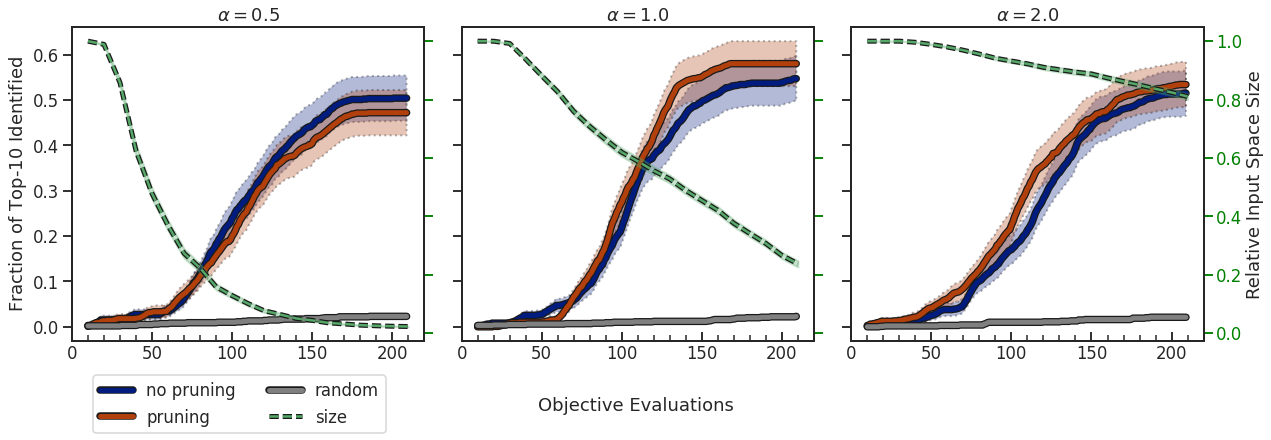

In [24]:
fig, axs_1 = plt.subplots(1, 3, figsize=(6 * 3, 6), sharex=True, sharey=True)

N = 10000
k = 10
ds = 42
T = 20
t = np.arange(T+1)

runs_dir = Path.home() / "active-projects/boip/runs/10000-10+20x10-unc"
npzdirs = list(runs_dir.iterdir())

palette = sns.color_palette(None, len(npzdirs))
obj = boip.build_objective("michalewicz")
choices = boip.objectives.discretize(obj, N, ds) 

y_all = obj(choices).numpy()
optimal_idxs = np.argpartition(y_all, -k)[-k:]
optimal_choices = choices[optimal_idxs]
optima = y_all[optimal_idxs]

axs_2 = []
for ax1, npzdir in zip(axs_1, npzdirs):
    tokens = npzdir.name.split('-')
    label = tokens[-1].split("=")[-1]

    X_npz = np.load(f"{npzdir}/X.npz")
    Xs = [X_npz[k] for k in X_npz]

    Y_npz = np.load(f"{npzdir}/Y.npz")
    Ys = [Y_npz[k] for k in Y_npz]

    y_all = obj(choices).numpy()
    optimal_idxs = np.argpartition(y_all, -k)[-k:]
    optimal_choices = choices[optimal_idxs]
    optima = y_all[optimal_idxs]

    ax1 = plot_IR(ax1, Ys, n, optima, ["no pruning", "pruning"], obj, choices, k)
    ax1.xaxis.set_minor_locator(MultipleLocator(10))
    ax1.tick_params(axis="x", which="both", direction="in", bottom=True)

    H = np.load(f"{npzdir}/H.npz")["PRUNE"]
    ax2 = ax1.twinx()
    plot_size_H(ax2, H[:,:,1], q, T)
    axs_2.append(ax2)

    ax1.set_title(rf"$\alpha={label}$")

for ax2 in axs_2[:-1]:
    ax2.sharey(axs_2[-1])
    ax2.tick_params('y', labelright=False, colors='green')
axs_2[-1].tick_params('y', colors='green')

handles1, labels1 = axs_1[0].get_legend_handles_labels()
handles2, labels2 = axs_2[0].get_legend_handles_labels()

fig.legend(
    [*handles1, *handles2],
    [*labels1, *labels2],
    ncol=2,
    bbox_to_anchor=(0.075, -0.05),
    loc="lower left",
)

axs_1[0].set_ylabel(r"Fraction of Top-$10$ Identified")
axs_2[-1].set_ylabel("Relative Input Space Size")
fig.supxlabel("Objective Evaluations", fontsize=18)

fig.tight_layout()
fig.savefig("../figures/michalewicz-alpha.png", dpi=200)

## Design Space Pruning

[back to top](#table-of-contents)

In [8]:
def plot_surface_discrete(
    ax,
    obj: BaseTestProblem,
    choices: Tensor,
    hits: np.ndarray,
    title: Optional[str] = None,
):
    """plot the level surface of the given objective onto the specified axis

    Parameters
    ----------
    ax
        the axis onto which the level surface should be plotted
    obj : BaseTestProblem
        the objective to which the level surface corresponds
    Xs : Iterable[np.ndarray]
        an iterable of `r x t x d` arrays. Where each entry in each array corresponds to the
        d-dimensional point acquired at iteration t of trial r
    hits: np.ndarray
    title : Optional[str], default=None
        the title to use for the plot. If None, use the name of the objective function

    Returns
    -------
    ax
        the axis on which the surface was plotted
    """
    Z = -obj(choices).numpy()

    ax.scatter(choices[:, 0], choices[:, 1], c=Z, s=10, cmap="coolwarm", alpha=0.7, zorder=0)
    ax.plot(hits[:, 0], hits[:, 1], "y*", ms=12, mec="black", zorder=2)

    # ax.set_title(title if title is not None else str(obj)[:-2])
    ax.tick_params(
        labelcolor="none",
        which="both",
        top=False,
        bottom=False,
        left=False,
        right=False,
    )

    return ax
    
def prune(choices: np.ndarray, H: np.ndarray, i: int) -> np.ndarray:
    mask = np.ones(len(choices), bool)
    mask[(1 <= H) & (H <= i)] = False

    return choices[mask]

def plot_acquired_points(ax, X):
    ax.scatter(X[:,0], X[:,1], s=20, c="none", edgecolor='k', linewidth=2, alpha=0.5, zorder=1)

    return ax

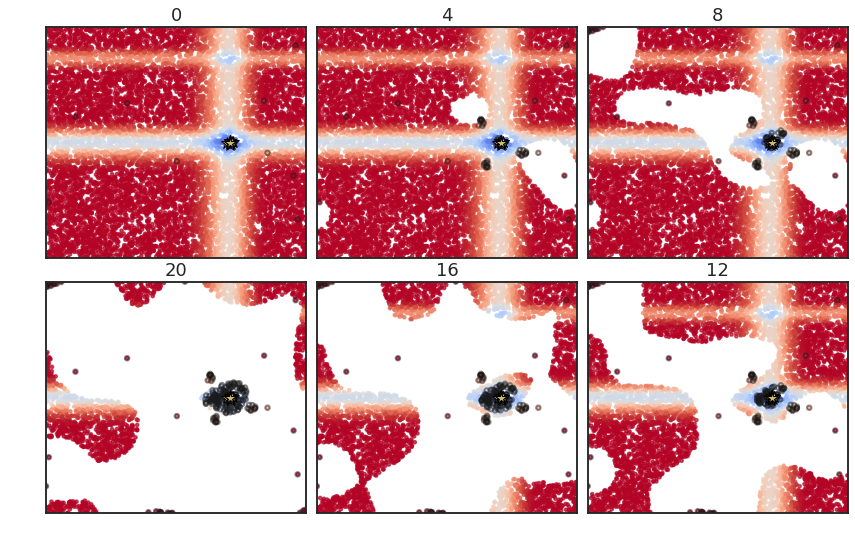

In [7]:
N = 6
fig, axs = plt.subplots(2, N//2, figsize=(2*N, 2*4), sharex=True, sharey=True)

npzdir = Path('/home/degraff/active-projects/boip/runs/10000-10+20x10-new/michalewicz')
obj = boip.objectives.build_objective(npzdir.stem)
choices = boip.objectives.discretize(obj, 10000, 42) 

n = 10
q = 10
k = 10

xmin, ymin = choices.min(0)[0].numpy()
xmax, ymax = choices.max(0)[0].numpy()

y_all = obj(choices).numpy()
hit_idxs = np.argpartition(y_all, -k)[-k:]
hits = choices[hit_idxs]

X = np.load(f"{npzdir}/X.npz")["PRUNE"]
H = np.load(f"{npzdir}/H.npz")["PRUNE"]

for x in range(N):
    i = x//3
    j = (-1 - x%3) if i%2==1 else x%3
    ax = axs[i][j]

    plot_surface_discrete(ax, obj, prune(choices, H[1,:,1], 4*x), hits, 4*x)
    # plot_acquired_points(ax, X[1,:4*x*q+n])

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

fig.tight_layout()
fig.subplots_adjust(wspace=0.04, hspace=0.1)


In [ ]:
fig.savefig(
  "../figures/michalewicz-design-space-prune+acquire.png", dpi=200,
  bbox_inches='tight', pad_inches=0
)

In [ ]:
npzdir = Path('/home/degraff/active-projects/boip/runs/10000-10+20x10-new/michalewicz')
obj = boip.objectives.build_objective(npzdir.stem)
choices = boip.objectives.discretize(obj, 10000, 42) 
Z = -obj(choices).numpy()

xmin, ymin = choices.min(0)[0].numpy()
xmax, ymax = choices.max(0)[0].numpy()

n = 10
q = 10
k = 10

y_all = obj(choices).numpy()
hit_idxs = np.argpartition(y_all, -k)[-k:]
hits = choices[hit_idxs]

X = np.load(f"{npzdir}/X.npz")["PRUNE"]
H = np.load(f"{npzdir}/H.npz")["PRUNE"]

for i in range(21):
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))

    X = prune(choices, H[1,:,1], i)
    c = prune(Z, H[1,:,1], i)
    
    ax.scatter(X[:, 0], X[:, 1], c=c, s=10, cmap="coolwarm", alpha=0.7, zorder=0)
    ax.plot(hits[:, 0], hits[:, 1], "y*", ms=12, mec="black", zorder=2)

    ax.tick_params(
        labelcolor="none",
        which="both",
        top=False,
        bottom=False,
        left=False,
        right=False,
    )
    
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    fig.savefig(
        f"../figures/michalewicz-pruning/iter_{i}.png", dpi=200, bbox_inches='tight', pad_inches=0
    )